In [1]:
# -----------------------------------------------------------------------------
# Environment Setup and Imports
# -----------------------------------------------------------------------------
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import pygame

# Initialize pygame if not already initialized
if not pygame.get_init():
    pygame.init()

# Get current working directory and add configuration directory to the system path.
current_dir: str = os.getcwd()
config_dir: str = os.path.abspath(os.path.join(current_dir, "../src/environment"))
if config_dir not in sys.path:
    sys.path.append(config_dir)

# Project-specific imports
from utils import intercept_direction, can_intercept

pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


2025-03-22 19:18:45.096243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742681925.187123  105344 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742681925.215982  105344 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 19:18:45.449604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.makedirs('../images', exist_ok=True)

In [3]:
def intercept_point_initial(chaser_pos: pygame.math.Vector2,
                            chaser_speed: float,
                            target_pos: pygame.math.Vector2,
                            target_vel: pygame.math.Vector2) -> pygame.math.Vector2:
    """
    Calcula o ponto de interceptação usando os valores iniciais.
    Se não houver solução válida, retorna target_pos.
    """
    r = target_pos - chaser_pos
    a = target_vel.dot(target_vel) - chaser_speed ** 2
    b = 2 * r.dot(target_vel)
    c = r.dot(r)
    
    t = 0.0
    if abs(a) < 1e-6:
        if abs(b) > 1e-6:
            t = -c / b
    else:
        discriminant = b**2 - 4 * a * c
        if discriminant >= 0:
            sqrt_disc = math.sqrt(discriminant)
            t1 = (-b + sqrt_disc) / (2 * a)
            t2 = (-b - sqrt_disc) / (2 * a)
            t_candidates = [t_val for t_val in (t1, t2) if t_val > 0]
            if t_candidates:
                t = min(t_candidates)
    if t <= 0:
        return target_pos
    else:
        return target_pos + target_vel * t

In [4]:
def run_simulation(chaser_pos: pygame.math.Vector2,
                   chaser_speed: float,
                   target_pos: pygame.math.Vector2,
                   point_of_interest: pygame.math.Vector2,
                   dt: float,
                   catch_threshold: float = 0.5,
                   poi_threshold: float = 0.5,
                   spiral_factor: float = 0.5,
                   target_speed: float = 1.0):
    """
    Executa a simulação passo a passo.
    
    O alvo se move em espiral até o PI: a cada passo, sua velocidade é definida pela soma
    de uma componente radial (para aproximar do PI) e de uma componente tangencial (para gerar giro).
    
    A simulação encerra quando:
      - O perseguidor alcança o alvo (distância < catch_threshold), ou
      - O alvo atinge o ponto de interesse (distância < poi_threshold).
    
    Retorna:
      - chaser_traj: trajetória do perseguidor.
      - target_traj: trajetória real do alvo.
      - intercept_flag: True se o perseguidor interceptou o alvo.
    """
    chaser_traj = []
    target_traj = []
    time_elapsed = 0.0
    intercept_flag = False

    chaser = chaser_pos.copy()
    target = target_pos.copy()

    while True:
        chaser_traj.append((chaser.x, chaser.y))
        target_traj.append((target.x, target.y))
        
        if chaser.distance_to(target) < catch_threshold:
            intercept_flag = True
            print(f"Perseguidor alcançou o alvo em {time_elapsed:.2f} s!")
            break
        if target.distance_to(point_of_interest) < poi_threshold:
            print(f"Alvo atingiu o ponto de interesse em {time_elapsed:.2f} s!")
            break

        radial_dir = point_of_interest - target
        radial_dir = radial_dir.normalize() if radial_dir.length() > 0 else pygame.math.Vector2(0, 0)
        tangential_dir = pygame.math.Vector2(-radial_dir.y, radial_dir.x)
        current_target_vel = radial_dir + spiral_factor * tangential_dir
        current_target_vel = current_target_vel.normalize() * target_speed if current_target_vel.length() > 0 else pygame.math.Vector2(0, 0)
        
        direction = intercept_direction(chaser, chaser_speed, target, current_target_vel)
        chaser += direction * chaser_speed * dt
        target += current_target_vel * dt
        
        time_elapsed += dt

    return np.array(chaser_traj), np.array(target_traj), intercept_flag

In [5]:
def run_intended_trajectory(target_pos: pygame.math.Vector2,
                             point_of_interest: pygame.math.Vector2,
                             dt: float,
                             spiral_factor: float,
                             target_speed: float,
                             poi_threshold: float = 0.5):
    """
    Simula a trajetória "pretendida" do alvo, seguindo o mesmo movimento espiral,
    até que o alvo atinja o ponto de interesse (distância < poi_threshold).
    
    Retorna a trajetória pretendida como um array de posições.
    """
    traj = []
    target = target_pos.copy()
    while target.distance_to(point_of_interest) >= poi_threshold:
        traj.append((target.x, target.y))
        radial_dir = point_of_interest - target
        radial_dir = radial_dir.normalize() if radial_dir.length() > 0 else pygame.math.Vector2(0, 0)
        tangential_dir = pygame.math.Vector2(-radial_dir.y, radial_dir.x)
        current_target_vel = radial_dir + spiral_factor * tangential_dir
        current_target_vel = current_target_vel.normalize() * target_speed if current_target_vel.length() > 0 else pygame.math.Vector2(0, 0)
        target += current_target_vel * dt
    traj.append((point_of_interest.x, point_of_interest.y))
    return np.array(traj)

Perseguidor alcançou o alvo em 221.40 s!


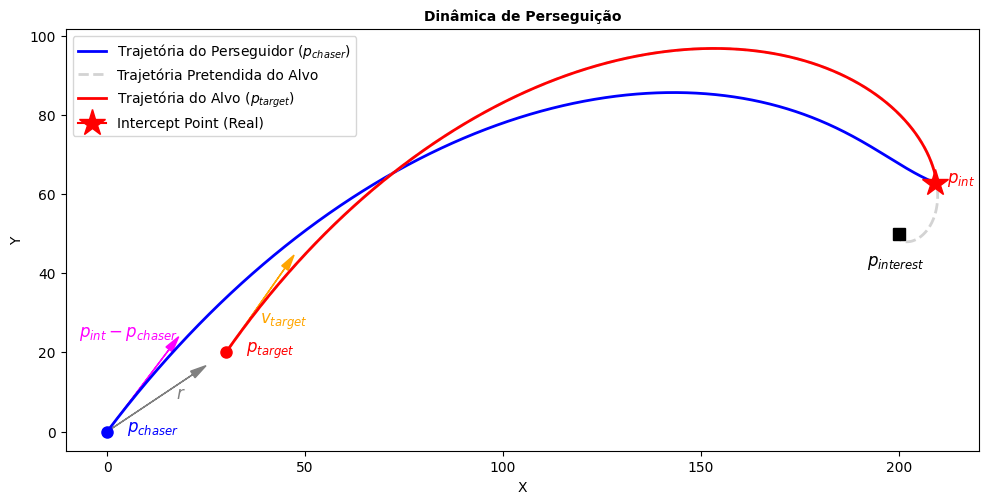

In [6]:
# Configuração do cenário
chaser_init = pygame.math.Vector2(0, 0)
target_init = pygame.math.Vector2(30, 20)
point_of_interest = pygame.math.Vector2(200, 50)

# Parâmetros de velocidade
target_speed = 1.0
chaser_speed = 1.1 * target_speed

# Parâmetros da simulação
dt = 0.1
catch_threshold = 0.5
poi_threshold = 0.5
spiral_factor = 1

# Executa a simulação principal
chaser_traj, target_traj, intercepted = run_simulation(chaser_init, chaser_speed, target_init,
                                                        point_of_interest, dt,
                                                        catch_threshold, poi_threshold,
                                                        spiral_factor, target_speed)

# Executa a simulação da trajetória pretendida do alvo até o PI
intended_traj = run_intended_trajectory(target_init, point_of_interest, dt, spiral_factor, target_speed, poi_threshold)

# Para fins de plot, o ponto de interceptação que de fato ocorreu:
if intercepted:
    p_i_actual = pygame.math.Vector2(chaser_traj[-1][0], chaser_traj[-1][1])
else:
    p_i_actual = None

# O vetor de interceptação a ser desenhado é calculado com base no intercept point
# obtido na primeira iteração (usando os valores iniciais)
p_i_initial = intercept_point_initial(chaser_init, chaser_speed, target_init,
                                      ( (point_of_interest - target_init).normalize() + spiral_factor * pygame.math.Vector2(-(point_of_interest - target_init).normalize().y, (point_of_interest - target_init).normalize().x) ).normalize() * target_speed)

# Fator de escala para os vetores
scale = 30

# Vetor r: de p_c até p_t (usando os valores iniciais)
r_vec = target_init - chaser_init
r_norm = r_vec.normalize() * scale if r_vec.length() > 0 else r_vec

# Vetor v_t: velocidade inicial do alvo conforme modelo espiral (valores iniciais)
radial_dir = point_of_interest - target_init
radial_dir = radial_dir.normalize() if radial_dir.length() > 0 else pygame.math.Vector2(0, 0)
tangential_dir = pygame.math.Vector2(-radial_dir.y, radial_dir.x)
v_t = (radial_dir + spiral_factor * tangential_dir)
v_t_norm = v_t.normalize() * scale if v_t.length() > 0 else v_t

# Vetor de interceptação: de p_c até o p_i inicial
intercept_vec = p_i_initial - chaser_init
intercept_norm = intercept_vec.normalize() * scale if intercept_vec.length() > 0 else intercept_vec

# Plotagem sem grid
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Dinâmica de Perseguição", fontsize=10, fontweight='bold')  
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_aspect('equal')

# Trajetória do perseguidor (azul)
ax.plot(chaser_traj[:, 0], chaser_traj[:, 1], 'b-', linewidth=2, label="Trajetória do Perseguidor ($p_{chaser}$)")
# Trajetória pretendida do alvo (espiral) em cinza claro
ax.plot(intended_traj[:, 0], intended_traj[:, 1], color='#d3d3d3', linestyle='--', linewidth=2,
        label="Trajetória Pretendida do Alvo")
# Trajetória real do alvo (vermelha)
ax.plot(target_traj[:, 0], target_traj[:, 1], 'r-', linewidth=2, label="Trajetória do Alvo ($p_{target}$)")

# Pontos:
ax.plot(chaser_init.x, chaser_init.y, 'bo', markersize=8)
ax.text(chaser_init.x + 5, chaser_init.y, "$p_{chaser}$", color='blue', fontsize=12)
ax.plot(target_init.x, target_init.y, 'ro', markersize=8)
ax.text(target_init.x + 5, target_init.y, "$p_{target}$", color='red', fontsize=12)
ax.plot(point_of_interest.x, point_of_interest.y, 'ks', markersize=8)
ax.text(point_of_interest.x - 8, point_of_interest.y - 8, "$p_{interest}$", color='black', fontsize=12)

# Se a interceptação ocorreu, marca o ponto de interceptação real
if p_i_actual is not None:
    ax.plot(p_i_actual.x, p_i_actual.y, marker='*', markersize=20,
            color='red', label="Intercept Point (Real)")
    ax.text(p_i_actual.x + 3, p_i_actual.y, "$p_{int}$", color='red', fontsize=12)
else:
    ax.plot([], [], marker='*', markersize=20, color='red', label="Ponto de Interceptação")

# Vetores (calculados a partir dos valores iniciais):
# Vetor r (de p_c até p_t)
ax.arrow(chaser_init.x, chaser_init.y, r_norm.x, r_norm.y, head_width=2, head_length=4,
         fc='gray', ec='gray', length_includes_head=True)
ax.text(chaser_init.x + r_norm.x/2 + 5, chaser_init.y + r_norm.y/2, "$r$", color='gray', fontsize=12)

# Vetor v_t (de p_t, representando a velocidade inicial do alvo)
ax.arrow(target_init.x, target_init.y, v_t_norm.x, v_t_norm.y, head_width=2, head_length=4,
         fc='orange', ec='orange', length_includes_head=True)
ax.text(target_init.x + v_t_norm.x/2, target_init.y + v_t_norm.y/2 - 5, "$v_{target}$", color='orange', fontsize=12)

# Vetor de interceptação (de p_c até p_i inicial)
ax.arrow(chaser_init.x, chaser_init.y, intercept_norm.x, intercept_norm.y, head_width=2, head_length=4, # linewidth=2,
         fc='magenta', ec='magenta', length_includes_head=True)
ax.text(chaser_init.x - intercept_norm.x/2.5, chaser_init.y + intercept_norm.y, "$p_{int}-p_{chaser}$", color='magenta', fontsize=12)

ax.legend(loc='upper left')

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.savefig(f'../images/intercept.png', format='png', bbox_inches='tight')
plt.show()
plt.close()




In [7]:
chaser_init = pygame.math.Vector2(0, 0)
target_init = pygame.math.Vector2(30, 20)
point_of_interest = pygame.math.Vector2(200, 50)

In [8]:
possible = can_intercept(chaser_init, chaser_speed, target_init, point_of_interest-target_init, point_of_interest)
print("É possível interceptar?" , possible)

É possível interceptar? False


In [9]:
pygame.quit()

/tmp/ipykernel_105344/1799661560.py:252: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[0, 0, 0.75, 0.9])


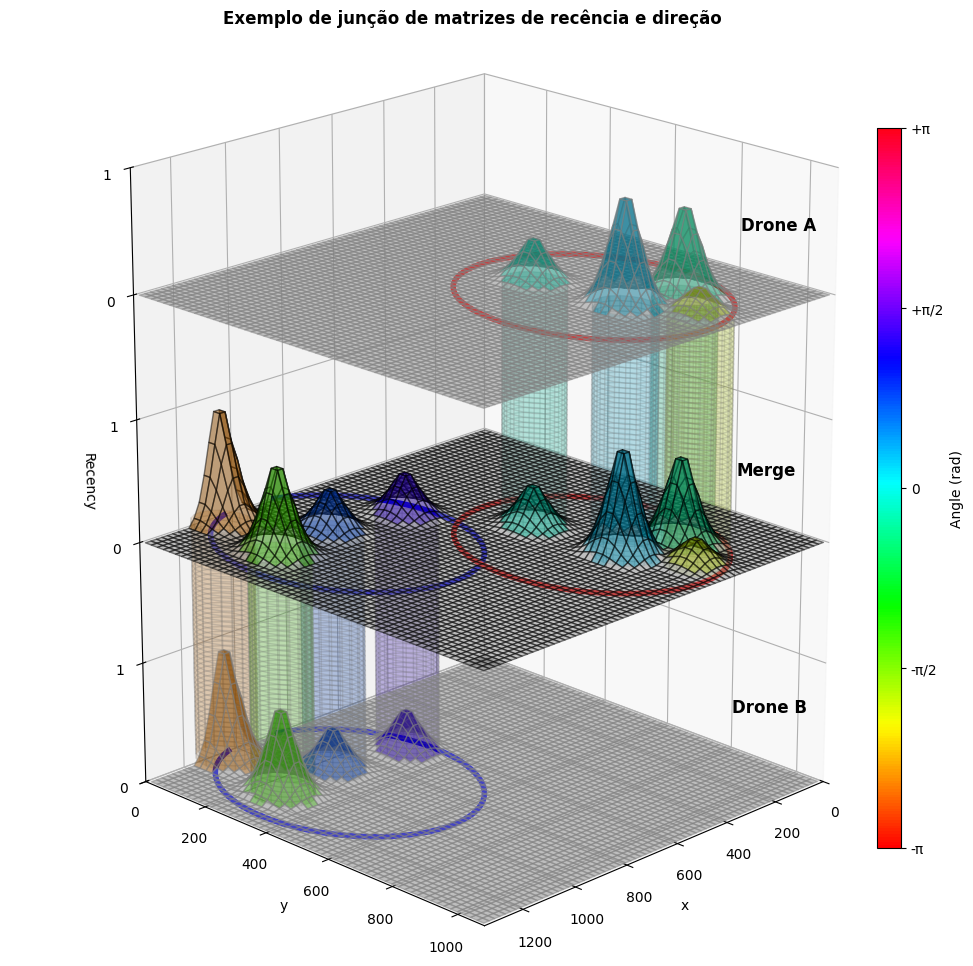

In [11]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib.lines import Line2D

# Adiciona o diretório de configuração ao sys.path, se necessário.
current_dir = os.getcwd()
config_dir = os.path.abspath(os.path.join(current_dir, "../src/environment"))
if config_dir not in sys.path:
    sys.path.append(config_dir)

# Imports específicos do projeto
from utils import smooth_matrix_with_kernel_10x10  # Mantemos a suavização
from settings import *

stride = 1  # Passo para o plot da superfície

# ============================
# Função para gerar matrizes de forma que os pontos fiquem dentro de um círculo
# ============================
def generate_sparse_matrix_in_circle(shape, max_nonzero, circle_center, circle_radius):
    """
    Gera uma matriz de intensidade e outra de direção, mas somente para pontos
    cujo centro (i+0.5, j+0.5) esteja dentro do círculo (circle_center, circle_radius).
    """
    w, h = shape
    intensity = np.zeros((w, h), dtype=float)
    direction = np.zeros((w, h, 2), dtype=float)

    candidates = []
    for i in range(w):
        for j in range(h):
            x_center = (i + 0.5) * CELL_SIZE
            y_center = (j + 0.5) * CELL_SIZE
            dx = x_center - circle_center[0]
            dy = y_center - circle_center[1]
            dist = math.sqrt(dx*dx + dy*dy)
            if dist <= circle_radius:
                candidates.append((i, j))

    np.random.shuffle(candidates)
    chosen = candidates[:max_nonzero]

    for (i, j) in chosen:
        val = np.random.rand()
        intensity[i, j] = val
        angle = 2 * math.pi * np.random.rand()
        direction[i, j, 0] = math.cos(angle)
        direction[i, j, 1] = math.sin(angle)

    return intensity, direction

def plot_circle_clipped(ax, center_x, center_y, radius, z_value, color,
                        linestyle='-', linewidth=4):
    """
    Gera e plota um círculo (x, y) dentro da área [0, SIM_WIDTH] x [0, SIM_HEIGHT],
    em z = z_value. Pontos fora desses limites são descartados e o círculo é dividido
    em segmentos para evitar fechamento indesejado.
    """
    theta = np.linspace(0, 2 * math.pi, 200)
    circle_x = center_x + radius * np.cos(theta)
    circle_y = center_y + radius * np.sin(theta)
    circle_z = np.full_like(theta, z_value)

    mask = (circle_x >= 0) & (circle_x <= SIM_WIDTH) & (circle_y >= 0) & (circle_y <= SIM_HEIGHT)

    segments = []
    start_idx = None
    for i in range(len(mask)):
        if mask[i] and start_idx is None:
            start_idx = i
        elif not mask[i] and start_idx is not None:
            segments.append((start_idx, i - 1))
            start_idx = None
    if start_idx is not None:
        segments.append((start_idx, len(mask) - 1))

    for (s_i, e_i) in segments:
        seg_x = circle_x[s_i:e_i + 1]
        seg_y = circle_y[s_i:e_i + 1]
        seg_z = circle_z[s_i:e_i + 1]
        seg_x = np.append(seg_x, np.nan)
        seg_y = np.append(seg_y, np.nan)
        seg_z = np.append(seg_z, np.nan)
        ax.plot(seg_x, seg_y, seg_z, color=color, linestyle=linestyle, linewidth=linewidth)

# ============================
# Geração Manual das Matrizes
# ============================
np.random.seed(42)

center_A_x = int(SIM_WIDTH * 0.7)
center_A_y = int(SIM_HEIGHT * 0.3)
detection_radius_A = SIM_WIDTH // 4

center_B_x = int(SIM_WIDTH * 0.35)
center_B_y = int(SIM_HEIGHT * 0.66)
detection_radius_B = SIM_WIDTH // 4

matrixA, directionA = generate_sparse_matrix_in_circle(
    (GRID_WIDTH, GRID_HEIGHT),
    max_nonzero=4,
    circle_center=(center_A_x, center_A_y),
    circle_radius=detection_radius_A
)
matrixB, directionB = generate_sparse_matrix_in_circle(
    (GRID_WIDTH, GRID_HEIGHT),
    max_nonzero=4,
    circle_center=(center_B_x, center_B_y),
    circle_radius=detection_radius_B
)

# ============================
# Suavização e Merge
# ============================
smoothedA, result_directionA = smooth_matrix_with_kernel_10x10(matrixA, directionA, sigma=2, flat_radius=1)
smoothedB, result_directionB = smooth_matrix_with_kernel_10x10(matrixB, directionB, sigma=2, flat_radius=1)
merged = np.maximum(smoothedA, smoothedB)
merged_direction = np.where(smoothedA[..., None] >= smoothedB[..., None],
                            result_directionA, result_directionB)
merged_nonsmooth = np.maximum(matrixA, matrixB)
merged_direction_nonsmooth = np.where(matrixA[..., None] >= matrixB[..., None],
                                      directionA, directionB)

# ============================
# Offsets
# ============================
offset_A = 0.0
offset_merge = 2.0
offset_B = 4.0

# ============================
# Criação da Grade para o Plot
# ============================
x = np.linspace(CELL_SIZE/2, SIM_WIDTH - CELL_SIZE/2, GRID_WIDTH)
y = np.linspace(CELL_SIZE/2, SIM_HEIGHT - CELL_SIZE/2, GRID_HEIGHT)
X, Y = np.meshgrid(x, y, indexing='ij')

Z_A = smoothedA + offset_A
Z_B = smoothedB + offset_B
Z_Merged = merged + offset_merge

# ============================
# Mapeamento de Cores (HSV)
# ============================
cmap = plt.cm.hsv

angleA = np.arctan2(result_directionA[..., 1], result_directionA[..., 0])
norm_angleA = (angleA + math.pi) / (2 * math.pi)
facecolorsA = cmap(norm_angleA)
facecolorsA[smoothedA < PLOT_THRESHOLD] = [1, 1, 1, 1]

angleB = np.arctan2(result_directionB[..., 1], result_directionB[..., 0])
norm_angleB = (angleB + math.pi) / (2 * math.pi)
facecolorsB = cmap(norm_angleB)
facecolorsB[smoothedB < PLOT_THRESHOLD] = [1, 1, 1, 1]

angleM = np.arctan2(merged_direction[..., 1], merged_direction[..., 0])
norm_angleM = (angleM + math.pi) / (2 * math.pi)
facecolorsM = cmap(norm_angleM)
facecolorsM[merged < PLOT_THRESHOLD] = [1, 1, 1, 0]

# ============================
# Criação da Figura 3D
# ============================
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z_A, facecolors=facecolorsA, rstride=stride, cstride=stride,
                alpha=0.5, edgecolor='gray')
ax.plot_surface(X, Y, Z_Merged, facecolors=facecolorsM, rstride=stride, cstride=stride,
                alpha=0.5, edgecolor='black')
ax.plot_surface(X, Y, Z_B, facecolors=facecolorsB, rstride=stride, cstride=stride,
                alpha=0.5, edgecolor='gray')

ax.view_init(elev=20, azim=45)
ax.set_box_aspect((1, 1, 4/3))

# ============================
# Plotando os círculos com clipping (somente pontos dentro da área de plotagem)
# ============================
plot_circle_clipped(ax, center_x=center_A_x, center_y=center_A_y, radius=detection_radius_A, 
                    z_value=offset_A, color='blue', linestyle='-', linewidth=4)
plot_circle_clipped(ax, center_x=center_B_x, center_y=center_B_y, radius=detection_radius_B, 
                    z_value=offset_B, color='red', linestyle='-', linewidth=4)
plot_circle_clipped(ax, center_x=center_A_x, center_y=center_A_y, radius=detection_radius_A, 
                    z_value=offset_merge, color='blue', linestyle='-', linewidth=4)
plot_circle_clipped(ax, center_x=center_B_x, center_y=center_B_y, radius=detection_radius_B, 
                    z_value=offset_merge, color='red', linestyle='-', linewidth=4)

# ============================
# Função para plotar tubos
# ============================
def plot_tube_from_to(ax, x_center, y_center, z_start, z_end, tube_radius, color):
    num_theta = 20
    num_z = 50
    theta = np.linspace(0, 2*math.pi, num_theta)
    z_vals = np.linspace(z_start, z_end, num_z)
    Theta, Z_tube = np.meshgrid(theta, z_vals)
    X_tube = x_center + tube_radius * np.cos(Theta)
    Y_tube = y_center + tube_radius * np.sin(Theta)
    ax.plot_surface(X_tube, Y_tube, Z_tube, color=color, rstride=stride, cstride=stride,
                    alpha=0.15, edgecolor='gray')

tube_radius = 80

# ============================
# Plotando tubos para pontos de detecção
# ============================
for i in range(GRID_WIDTH):
    for j in range(GRID_HEIGHT):
        # Drone A: verifica se o ponto está dentro do círculo de detecção de A
        x_center = (i + 0.5) * CELL_SIZE
        y_center = (j + 0.5) * CELL_SIZE
        dA = math.sqrt((x_center - center_A_x)**2 + (y_center - center_A_y)**2)
        if matrixA[i, j] >= PLOT_THRESHOLD and dA <= detection_radius_A:
            plot_tube_from_to(ax, x_center, y_center, offset_A, offset_merge, tube_radius,
                              cmap((math.atan2(directionA[i, j, 1], directionA[i, j, 0]) + math.pi) / (2*math.pi)))
        # Drone B: verifica se o ponto está dentro do círculo de detecção de B
        dB = math.sqrt((x_center - center_B_x)**2 + (y_center - center_B_y)**2)
        if matrixB[i, j] >= PLOT_THRESHOLD and dB <= detection_radius_B:
            plot_tube_from_to(ax, x_center, y_center, offset_B, offset_merge, tube_radius,
                              cmap((math.atan2(directionB[i, j, 1], directionB[i, j, 0]) + math.pi) / (2*math.pi)))

# ============================
# Ticks e Grid
# ============================
ax.set_xlim(0, SIM_WIDTH)
ax.set_ylim(0, SIM_HEIGHT)
ax.set_zlim(0, offset_B + 1)

# ax.set_xticks(np.linspace(0, SIM_WIDTH, 20))
# ax.set_yticks(np.linspace(0, SIM_HEIGHT, 20))
ax.set_ylabel('y')
ax.set_xlabel('x')
# Para o eixo Z, queremos três seções de 0 a 2 concatenadas (total 0 a 6)
ax.set_zticks([0, 1, 2, 3, 4, 5])
ax.set_zticklabels(['0','1','0','1','0','1'])
ax.set_zlabel('Recency')

ax.text(0, 800, 4.3, "Drone A", color="black", fontsize=12, fontweight='bold')
ax.text(0, 800, 2.3, "Merge", color="black", fontsize=12, fontweight='bold')
ax.text(0, 800, 0.3, "Drone B", color="black", fontsize=12, fontweight='bold')


ax.grid(True)

ax.set_title("Exemplo de junção de matrizes de recência e direção", fontsize=12, fontweight='bold')
fig.tight_layout(rect=[0, 0, 0.75, 0.9])

norm = plt.Normalize(vmin=-math.pi, vmax=math.pi)
mappable_for_colorbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable_for_colorbar.set_array([])
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
cbar = fig.colorbar(mappable_for_colorbar, cax=cbar_ax, label='Angle (rad)')
cbar.set_ticks([-math.pi, -math.pi / 2, 0, math.pi / 2, math.pi])
cbar.set_ticklabels(['-π', '-π/2', '0', '+π/2', '+π'])

plt.savefig(f'../images/merge.png', format='png', bbox_inches='tight')
plt.show()
plt.close()


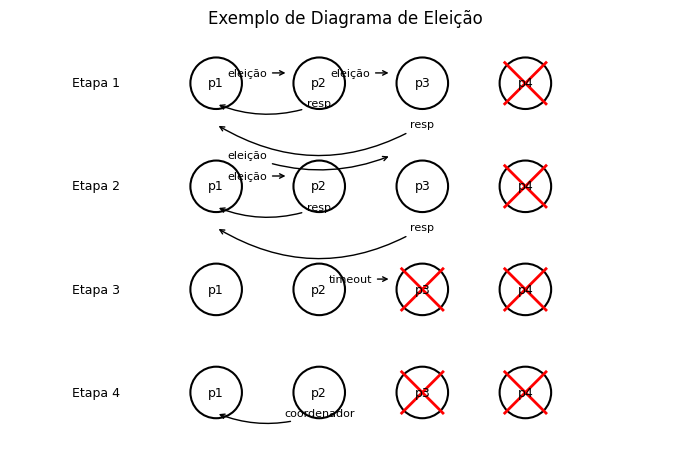

In [3]:
import matplotlib.pyplot as plt

def draw_process(ax, x, y, label, crossed=False):
    """
    Desenha um círculo para representar o processo (label) em (x, y).
    Se crossed=True, desenha um 'X' indicando falha.
    """
    circle = plt.Circle((x, y), 0.25, fill=False, color='black', lw=1.5)
    ax.add_patch(circle)
    ax.text(x, y, label, ha='center', va='center', fontsize=9)
    
    # Se estiver falho, desenha um 'X'
    if crossed:
        ax.plot([x - 0.2, x + 0.2], [y - 0.2, y + 0.2], color='red', lw=2)
        ax.plot([x - 0.2, x + 0.2], [y + 0.2, y - 0.2], color='red', lw=2)

def draw_arrow(ax, start, end, label, rad=0.2):
    """
    Desenha uma seta curvada de start para end, com texto 'label'.
    rad>0 = curva para cima, rad<0 = curva para baixo.
    """
    ax.annotate(
        label,
        xy=end,
        xytext=start,
        arrowprops=dict(
            arrowstyle='->',
            connectionstyle=f'arc3,rad={rad}',
            lw=1
        ),
        ha='center',
        va='center',
        fontsize=8
    )

# Cria a figura e o eixo principal
fig, ax = plt.subplots(figsize=(7, 5))

# Vamos colocar cada etapa em uma linha (y=3,2,1,0).
stages_y = [3, 2, 1, 0]
stage_labels = ["Etapa 1", "Etapa 2", "Etapa 3", "Etapa 4"]

# Rotular as etapas à esquerda
for i, label in enumerate(stage_labels):
    ax.text(-1.4, stages_y[i], label, va='center', fontsize=9)

################################
# ETAPA 1
################################
y1 = stages_y[0]
draw_process(ax, 0, y1, "p1")             # p1
draw_process(ax, 1, y1, "p2")             # p2
draw_process(ax, 2, y1, "p3")             # p3
draw_process(ax, 3, y1, "p4", crossed=True)  # p4 falho

# Mensagens
# p1 -> p2 (eleição)
draw_arrow(ax, (0.3, y1+0.1), (0.7, y1+0.1), "eleição", rad=0.0)
# p2 -> p3 (eleição)
draw_arrow(ax, (1.3, y1+0.1), (1.7, y1+0.1), "eleição", rad=0.0)
# p2 -> p1 (resp)
draw_arrow(ax, (1, y1-0.2), (0, y1-0.2), "resp", rad=-0.2)
# p3 -> p1 (resp)
draw_arrow(ax, (2, y1-0.4), (0, y1-0.4), "resp", rad=-0.3)

################################
# ETAPA 2
################################
y2 = stages_y[1]
draw_process(ax, 0, y2, "p1")
draw_process(ax, 1, y2, "p2")
draw_process(ax, 2, y2, "p3")
draw_process(ax, 3, y2, "p4", crossed=True)

# Mensagens
# p1 -> p2 (eleição)
draw_arrow(ax, (0.3, y2+0.1), (0.7, y2+0.1), "eleição", rad=0.0)
# p1 -> p3 (eleição)
draw_arrow(ax, (0.3, y2+0.3), (1.7, y2+0.3), "eleição", rad=0.2)
# p2 -> p1 (resp)
draw_arrow(ax, (1, y2-0.2), (0, y2-0.2), "resp", rad=-0.2)
# p3 -> p1 (resp)
draw_arrow(ax, (2, y2-0.4), (0, y2-0.4), "resp", rad=-0.3)

################################
# ETAPA 3
################################
y3 = stages_y[2]
draw_process(ax, 0, y3, "p1")
draw_process(ax, 1, y3, "p2")
draw_process(ax, 2, y3, "p3", crossed=True)
draw_process(ax, 3, y3, "p4", crossed=True)

# Mensagem: p2 -> p3 (timeout)
draw_arrow(ax, (1.3, y3+0.1), (1.7, y3+0.1), "timeout", rad=0.0)

################################
# ETAPA 4
################################
y4 = stages_y[3]
draw_process(ax, 0, y4, "p1")
draw_process(ax, 1, y4, "p2")
draw_process(ax, 2, y4, "p3", crossed=True)
draw_process(ax, 3, y4, "p4", crossed=True)

# Mensagem: p2 -> p1 (coordenador)
draw_arrow(ax, (1, y4-0.2), (0, y4-0.2), "coordenador", rad=-0.2)

# Ajustes finais do gráfico
ax.set_xlim(-2, 4.5)
ax.set_ylim(-0.5, 3.5)
ax.set_aspect('equal', adjustable='box')
ax.axis('off')

plt.title("Exemplo de Diagrama de Eleição", fontsize=12)
plt.tight_layout()
plt.show()
